In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from torch.optim import lr_scheduler

In [3]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([  # Changed to test dataset instead of val
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Define the data directory
data_dir = '/content/drive/MyDrive/Images'


In [5]:
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes

{'train': 3902, 'test': 977}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the final fully connected layer for 6 classes
model.fc = nn.Linear(model.fc.in_features, 6)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)  # Weight decay added

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
# Training loop with early stopping
num_epochs = 15
best_model_wts = model.state_dict()
best_acc = 0.0
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            test_losses.append(epoch_loss)
            test_accs.append(epoch_acc)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    scheduler.step()  # Update the learning rate

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/15
----------
train Loss: 1.1177 Acc: 0.6184
test Loss: 0.5729 Acc: 0.8362
Epoch 2/15
----------
train Loss: 0.7195 Acc: 0.7629
test Loss: 0.4564 Acc: 0.8547
Epoch 3/15
----------
train Loss: 0.6553 Acc: 0.7750
test Loss: 0.3772 Acc: 0.8772
Epoch 4/15
----------
train Loss: 0.6080 Acc: 0.7916
test Loss: 0.3373 Acc: 0.8895
Epoch 5/15
----------
train Loss: 0.5934 Acc: 0.7932
test Loss: 0.2980 Acc: 0.9079
Epoch 6/15
----------
train Loss: 0.5817 Acc: 0.7996
test Loss: 0.3024 Acc: 0.8915
Epoch 7/15
----------
train Loss: 0.5763 Acc: 0.8063
test Loss: 0.3243 Acc: 0.8802
Epoch 8/15
----------
train Loss: 0.5085 Acc: 0.8234
test Loss: 0.2847 Acc: 0.9079
Epoch 9/15
----------
train Loss: 0.5200 Acc: 0.8255
test Loss: 0.2873 Acc: 0.9089
Epoch 10/15
----------
train Loss: 0.5060 Acc: 0.8270
test Loss: 0.2977 Acc: 0.8946
Epoch 11/15
----------
train Loss: 0.5219 Acc: 0.8232
test Loss: 0.2800 Acc: 0.9120
Epoch 12/15
----------
train Loss: 0.5295 Acc: 0.8209
test Loss: 0.2717 Acc: 0.9161
E

<All keys matched successfully>

In [9]:
# Save the trained model
torch.save(model.state_dict(), 'best_classification_model_resnet50.pth')

In [10]:
# Evaluate model performance
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:  # Using test set for evaluation
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names)
    return cm, cr

In [11]:
# Get confusion matrix and classification report
cm, cr = evaluate_model(model, dataloaders['test'])
print("Classification Report:\n", cr)

Classification Report:
                   precision    recall  f1-score   support

          Aphids       0.81      0.95      0.87       164
       Army worm       0.90      0.93      0.92       162
Bacterial blight       0.95      0.81      0.88       160
         Healthy       0.85      0.99      0.91       165
  Powdery mildew       0.98      0.79      0.87       166
     Target spot       0.90      0.87      0.89       160

        accuracy                           0.89       977
       macro avg       0.90      0.89      0.89       977
    weighted avg       0.90      0.89      0.89       977



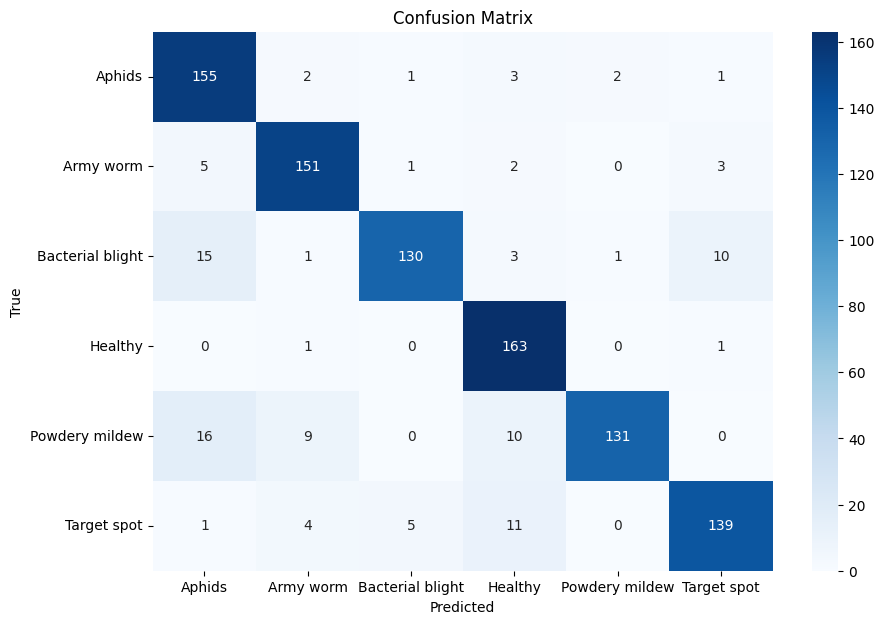

In [12]:
# Visualize Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The predicted class is: Powdery mildew with a confidence of 0.9562


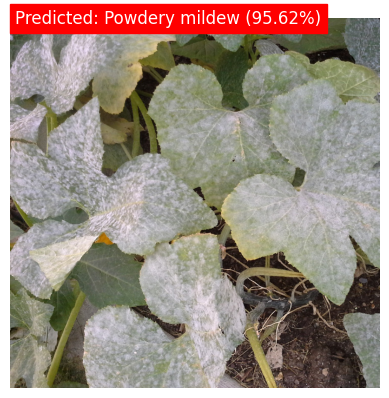

In [19]:
# Example image prediction with probabilities
image_path = '/content/powdery-mildew-winter-squash.jpg'  # Replace with your test image path
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

# Get predicted class and probability
predicted_class_name = class_names[predicted_class.item()]
predicted_prob = probabilities[0][predicted_class].item()

print(f'The predicted class is: {predicted_class_name} with a confidence of {predicted_prob:.4f}')

# Show the image with prediction
plt.imshow(np.array(image))
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name} ({predicted_prob*100:.2f}%)', fontsize=12, color='white', backgroundcolor='red')
plt.show()



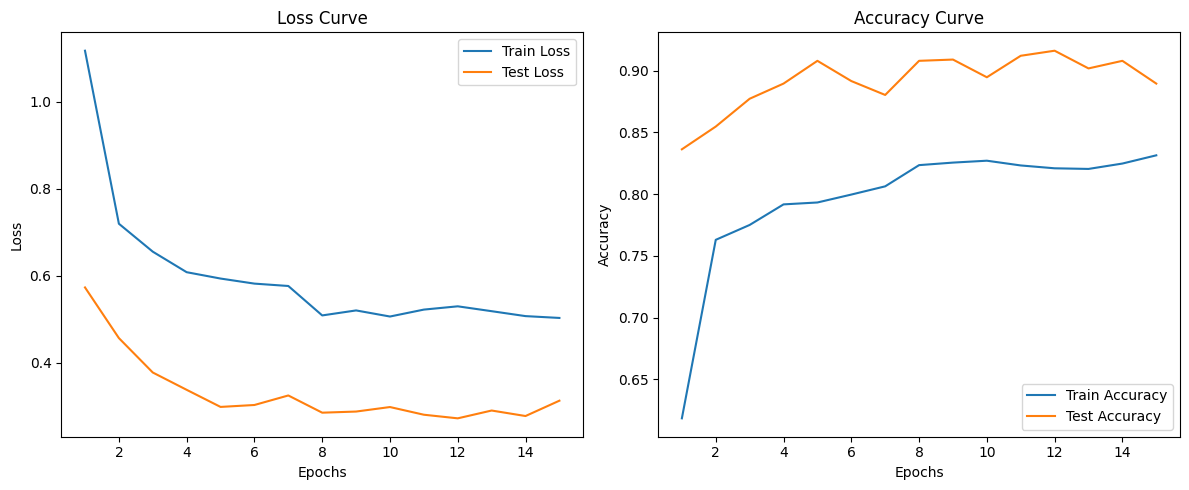

In [23]:
# Ensure all tensors in train_accs and test_accs are converted to Python floats
train_accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accs]
test_accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in test_accs]

# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
